# Classifiez automatiquement des biens de consommation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix

import sklearn.metrics as metrics
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from sklearn import decomposition, preprocessing
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stemmer    = EnglishStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA

import cv2
import imutils
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix

pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Downloading package stopwords to /home/yonss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yonss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yonss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
rstate=10
var_explained=0.75

# Extraction  des donnees

In [3]:
dir_data = Path('../DATA/P6') 
dir_fig  = Path('../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../DATA/P6/Flipkart') 
img_path = Path(str(CHECK_FOLDER) + str('/Images/'))
desc_data=str(dir_data)+'/df_clean.csv'

# Traitement d'image

In [4]:
name_img =[]

# Boucle sur les images
for image in listdir(img_path):
    name_img.append(image)

data = pd.DataFrame()
data["image"] = name_img
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["image"])

df =pd.read_csv(desc_data)
data_merged = pd.merge(
    data, df, left_on='image', right_on='image')


In [5]:
orb_description = []
sift_description = []

# Initiate SIFT / ORB detector
sift= cv2.xfeatures2d.SIFT_create()
orb = cv2.ORB_create()

orb_file        = Path(work_dir + '/orb_description_all.csv')
orb_file_by_img = Path(work_dir + '/orb_description_by_img.csv')
sift_file        = Path(work_dir + '/sift_description_all.csv')
sift_file_by_img = Path(work_dir + '/sift_description_by_img.csv')

if orb_file.exists():
    print('read descriptors files')
    orb_description_all = pd.read_csv(orb_file)  
    sift_description_all = pd.read_csv(sift_file)
    sift_description_all=sift_description_all.drop(['Unnamed: 0'],axis=1)
    orb_description_all =orb_description_all.drop(['Unnamed: 0'],axis=1)
    
    from numpy import genfromtxt
    orb_description_by_img   = genfromtxt('orb_description_by_img.csv', delimiter=',', dtype=None)
    sift_description_by_img = genfromtxt('sift_description_by_img.csv', delimiter=',', dtype=None)
    print('end read descriptors files')
else:
    # Boucle sur les images
    for image in data_merged['image']:
        # Chargement des images 
        image = cv2.imread(str(img_path)+'/'+image)

        # Convering to Gray
        img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

        # convert all picture to the same size
        img = imutils.resize(img, width=400)

        # Amélioration contraste
        img = cv2.equalizeHist(img) 

        # Débruitage
        img = cv2.fastNlMeansDenoising(img)

        # filtre gausien
        img = cv2.GaussianBlur(img, (5, 5), 1)

        # find the keypoints and descriptors with ORB
        Keypoint_orb , Descripteur_orb = orb.detectAndCompute(img,None)
        orb_description.append(Descripteur_orb)
        
        Keypoint_sift , Descripteur_sift = sift.detectAndCompute(img,None)
        sift_description.append(Descripteur_sift)

    orb_description_by_img = np.asarray(orb_description)
    orb_description_all        = np.concatenate(orb_description_by_img, axis=0)
    orb_description_pd     = pd.DataFrame(orb_description_all)
    
    
    sift_description_by_img = np.asarray(sift_description)
    sift_description_all        = np.concatenate(sift_description_by_img, axis=0)
    sift_description_pd     = pd.DataFrame(sift_description_all)
    
    # saving the dataframe
    #orb_description_pd.to_csv('orb_description_all.csv')   
    #sift_description_pd.to_csv('sift_description_all.csv')  
    #np.savetxt('orb_description_by_img.csv' , orb_description_by_img, fmt='%s')
    #np.savetxt('sift_description_by_img.csv', sift_description_by_img,  fmt='%s')

### Classification non supervisée 

In [6]:
Idetector= {
     'orb':  'kmeans_orb',
     "sift": 'kmeans_sift'
    } 
Duration_detector={
     'orb':  'duration_orb',
     "sift": 'duration_sift'
    } 

Data_detector={
     'orb':  orb_description_all,
     "sift": sift_description_all
    }
for k in  Idetector:
    print(k)
    nclusters = int(round(np.sqrt(len(Data_detector[k])),0))
    temps1=time.time()
    # Clustering
    Idetector[k] = cluster.MiniBatchKMeans(nclusters, init_size=3*nclusters, random_state=rstate)
    Idetector[k].fit(Data_detector[k])
    Duration_detector[k]=time.time()-temps1

    print('Duration',k,':',Duration_detector[k])

orb
Duration orb : 143.29286241531372
sift
Duration sift : 465.4899306297302


## Création des features des images

In [7]:
# Creation of histograms (features)

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
def hist_build(description_all,model):
    hist_vectors=[]
    for i, image_desc in enumerate(description_all) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(model, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)
    
    return im_features

In [8]:
Data_detector_img={
     'orb':  orb_description_by_img,
     "sift": sift_description_by_img
    }
im_feature_keap={'orb': 'im_feature_orb',
            "sift": 'im_feature_sift'}

for k in  Idetector:
    if Duration_detector['orb']<Duration_detector[k]:
        data_kept=Data_detector_img[k]
        model_kept=Idetector[k]
        im_feature=im_feature_keap[k]
        print('model kept is:',k)
        
temps1=time.time()
im_features=hist_build(data_kept,model_kept)
duration1=time.time()-temps1

print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


model kept is: sift
0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            20.48 secondes


## Réductions de dimension

### Réduction de dimension PCA

In [9]:
var_explained=0.75

def pca_red_dim(model_res,var_explained):
    pca = PCA(var_explained)  
    df_PCA = pca.fit_transform(model_res)
    num_pc = len(pca.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))] #["PC"+str(i) for i in list(range(1, num_pc+1))]
    X_pca   = pca.transform(model_res)
    return pc_list,pca,X_pca

def fig_pca(X_PCA,ax):
    chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
    ax.set_title(chaine)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    sns.scatterplot(
        x=X_PCA[:,0],
        y=X_PCA[:,1],
        hue=df['Category_0'],ax=ax,
        alpha=0.8,
        s=30
    )

[pc,pca,X_pca] = pca_red_dim(im_features,var_explained)

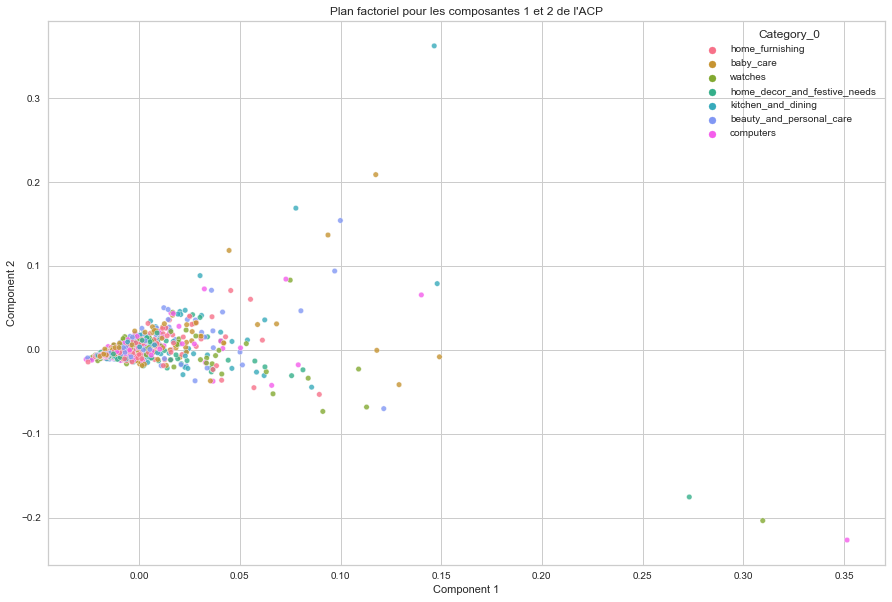

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
fig_pca(X_pca,ax)

In [11]:
tsne = TSNE(n_components=2, init="pca")
X_tsne  = tsne.fit_transform(X_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['Category_0']

In [12]:
def plot_tsne(df,ax,classe):
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=classe, data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    ax.set_title('TSNE selon les vraies classes', fontweight = 'bold')
    ax.set_xlabel('tsne1')
    ax.set_ylabel('tsne2')

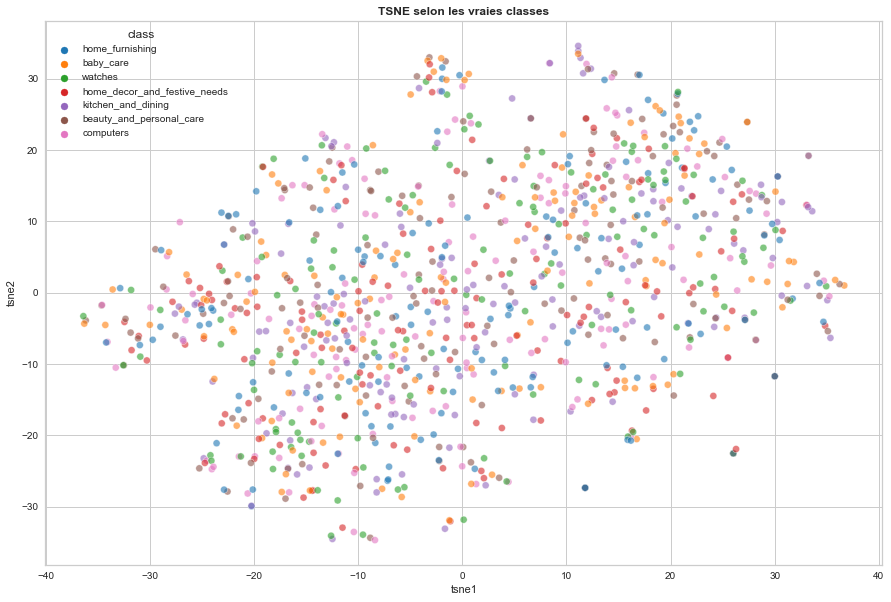

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tsne(df_tsne,ax,"class")

### Classification supervisée 

In [14]:
def fit_KMeans_model(df_X,nclusters,nstate):
    kmeans_visualizer = KMeans(n_clusters=nclusters,random_state=nstate)
    kmeans_visualizer.fit(df_X)
    name='Cluster = '+str(nclusters)
    label = kmeans_visualizer.labels_
    return label,name

In [15]:
[labels,name] = fit_KMeans_model(X_tsne,7,rstate)

df_tsne[name]=labels

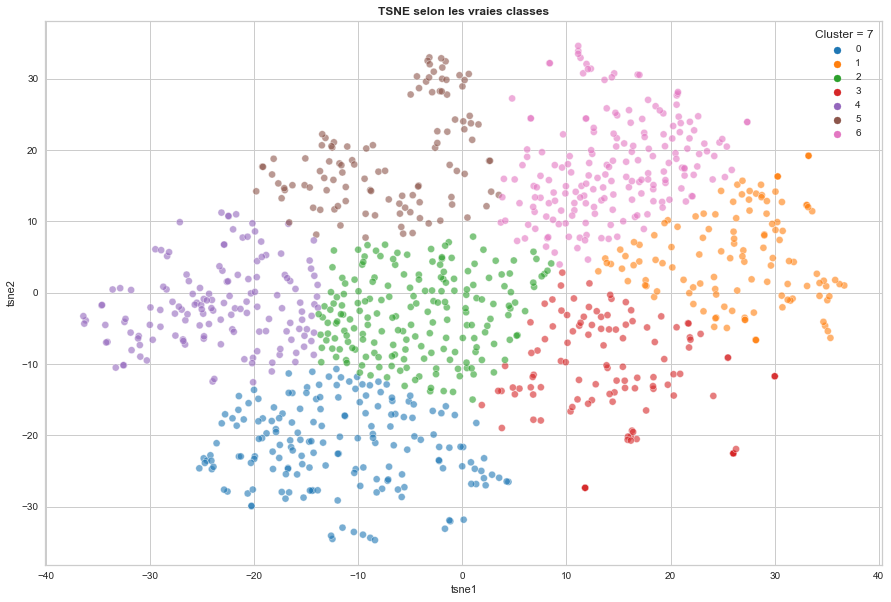

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tsne(df_tsne,ax,name)

In [17]:
from sklearn.metrics import precision_score, accuracy_score,recall_score, davies_bouldin_score
ARI_CAT_KMeans=adjusted_rand_score(data_merged['lab_category'],df_tsne[name])

accuracy = accuracy_score( data_merged['lab_category'],df_tsne[name])
precision= precision_score(data_merged['lab_category'],df_tsne[name], average='weighted')

algo_Performance={"Algorithme": "Kmeans", "ARI": ARI_CAT_KMeans,'accuracy':accuracy ,\
                  'precision':precision}
PerformanceK = pd.DataFrame( algo_Performance,
        index=[0],
    )

PerformanceK

,Algorithme,ARI,accuracy,precision
0,Kmeans,0.04,0.15,0.15


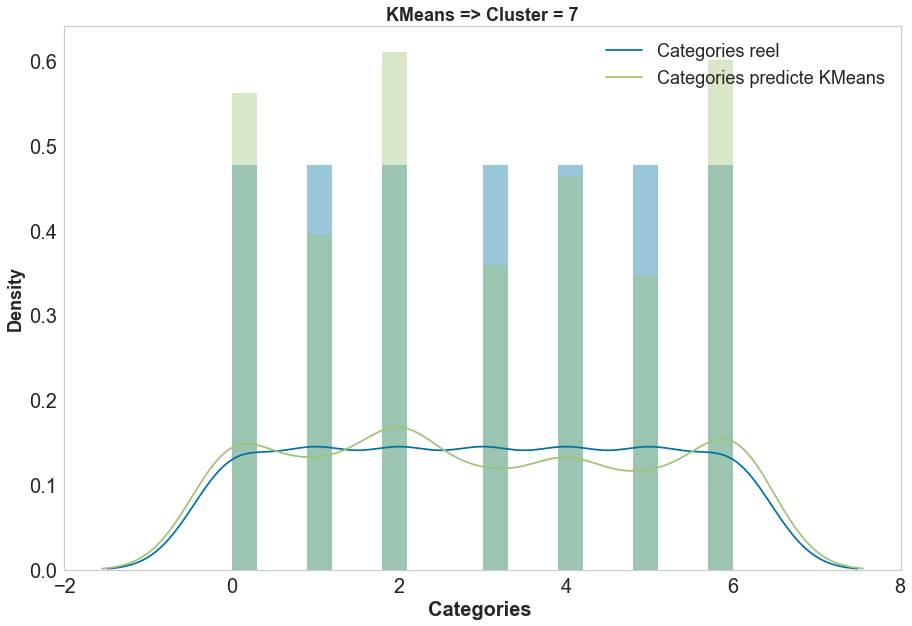

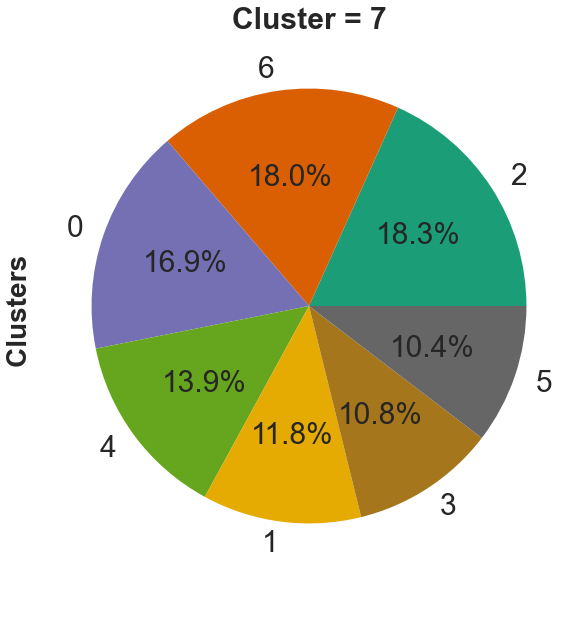

In [18]:
dss=20
tnx=0
names=["Density_kmeans_image.jpeg", "KMeans_pie_image.jpeg"]
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(df['lab_category'], bins=20, rug=False,ax=ax)
ax.set_title('KMeans => '+ name, weight='bold', size=dss-2)
sns.distplot(df_tsne[name], bins=20, rug=False,ax=ax)
ax.set_xlabel("Catégories")
ax.legend(['Categories reel', 'Categories predicte KMeans'], fontsize=dss-2)

ax.set_ylabel('Density', weight='bold', size=dss-2)
ax.set_xlabel('Categories ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]
        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

tnx=tnx+1
dss=30
fig, ax2 = plt.subplots(figsize=(25,10))
data_plot_0 = df_tsne.groupby(name).agg(Clusters =('class','count'))

data_plot_0=data_plot_0.sort_values(by='Clusters', ascending=False)
data_plot_0.plot(kind='pie', x=name, y='Clusters', title = '', 
cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(name,fontsize=dss, weight='bold');

ax2.set_ylabel('Clusters ', weight='bold', size=dss-2)
ax2.set_xlabel(' ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]

        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KMeans_pie_image.jpeg"  /home/yonss/Bureau/Data_scientist/FIGURE/P6
!mv "Density_kmeans_image.jpeg"  /home/yonss/Bureau/Data_scientist/FIGURE/P6


In [19]:
cmf = confusion_matrix(data_merged['lab_category'], df_tsne[name])

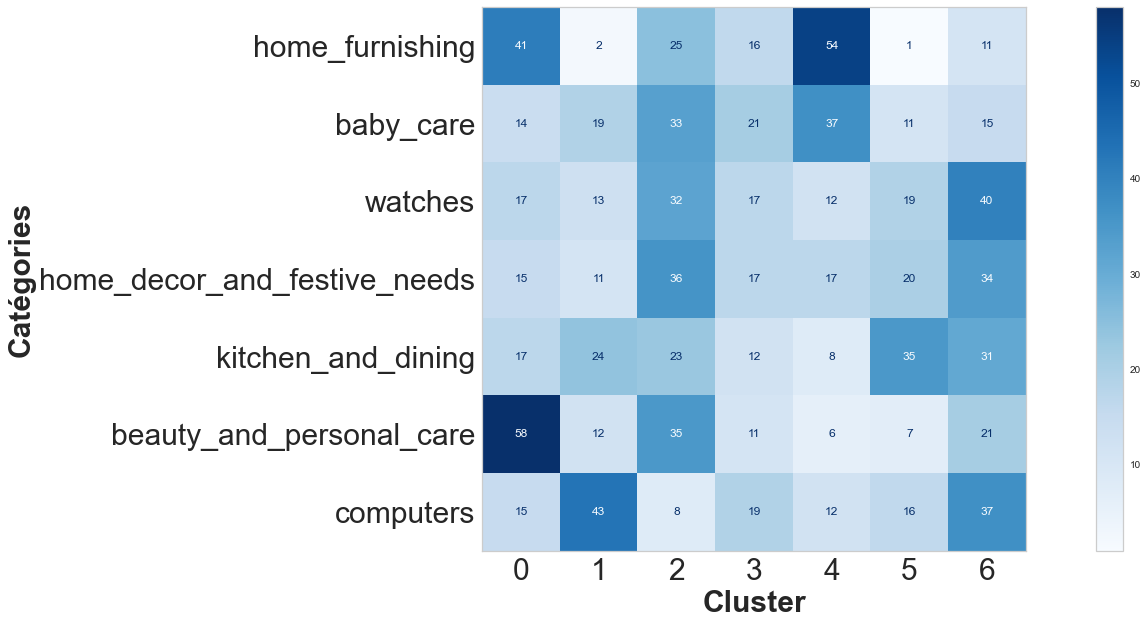

In [20]:
f, (ax1) = plt.subplots(1,1, figsize=(25,10))
cm_display = ConfusionMatrixDisplay(cmf).plot(ax=ax1,cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': dss})
ax1.set_ylabel("Catégories", weight='bold', size=dss)
ax1.set_xlabel('Cluster', weight='bold', size=dss)
ax1.set_yticklabels(df_tsne['class'].unique(), size=dss)
plt.xticks(fontsize=dss)
plt.grid(False)

# Classification supervisée 

In [21]:
Y=data_merged['lab_category']
Cat=df_tsne['class']
X=df_tsne.drop(['class',name],axis=1)

In [22]:
supervise=1
if supervise==1:
    params_Classifiers = {
     "RandomForestClassifier":     {'bootstrap': [True, False],'max_depth': [5,10,20],'max_features': [2, 4],'min_samples_leaf': [2, 4]},  
     'KNeighborsClassifier':       {'n_neighbors': [2,5],'weights': ['uniform','distance']}
    }
    seed = 10
    Classifiers = {
     "RandomForestClassifier": RandomForestClassifier(random_state=seed),
     'KNeighborsClassifier':  KNeighborsClassifier()
    }   
def Multi_output_improved_Classifier_model(Classifiers,params_regressors,X_train, y_train,Cat,n_splits,seed):
    
    results= pd.DataFrame(index=["RMSE",\
                                "best_estimator_","best_params_",'ARI','Silhouette_Score','accuracy_score','precision_score']) 
    
    Findex=['Cible predite']    
    frames_train= [] 
    column_Classifier=[]
   
    for ks in Classifiers:
        column_Classifier.append(ks)
#-------------------------------------------------------------------------------------------------------------

    for model_idx in Classifiers:       
        #
        print(model_idx)
        Classifier  = Classifiers[model_idx]
        param_grid= params_Classifiers[model_idx]
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        
        grid_search = GridSearchCV(estimator=Classifier, param_grid=param_grid, cv=kfold)
        
        grid_search.fit(X_train,  y_train)
        
        y_train_pred= grid_search.best_estimator_.predict(X_train)
        train_pred=pd.DataFrame(y_train_pred,index=y_train.index,columns=Findex)
       
        train_rmse=np.sqrt(mean_squared_error(y_train,train_pred)) 
     
        
        arii=adjusted_rand_score(y_train, y_train_pred)
        silh=silhouette_score(X_train,  y_train_pred)
        accu=accuracy_score(y_train, y_train_pred)
        prec=precision_score(y_train, y_train_pred, average='weighted')
        
        results[model_idx]=[train_rmse,grid_search.best_estimator_,grid_search.best_params_,arii, silh, accu,prec]
    
        Y_pred_train= pd.concat([y_train,train_pred,Cat],axis=1)
        frames_train.append(Y_pred_train)

    df_pred_train = pd.concat(frames_train, keys=column_Classifier, axis=1)
    
    results=results.T
    
    results=results.sort_values(by=["RMSE"],axis=0, ascending=True)
    return results,df_pred_train

nsplits=10
[eval_results_improved,pred_train_improved]=Multi_output_improved_Classifier_model\
             (Classifiers,params_Classifiers,X,Y,Cat,nsplits,seed)

RandomForestClassifier
KNeighborsClassifier


In [23]:
eval_results_improved.style.background_gradient(axis=None,cmap="coolwarm", subset=['RMSE'])

,RMSE,best_estimator_,best_params_,ARI,Silhouette_Score,accuracy_score,precision_score
KNeighborsClassifier,0.00,KNeighborsClassifier(weights='distance'),"{'n_neighbors': 5, 'weights': 'distance'}",1.00,-0.10,1.00,1.00
RandomForestClassifier,0.80,"RandomForestClassifier(max_depth=20, max_features=2, min_samples_leaf=2, random_state=10)","{'bootstrap': True, 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 2}",0.83,-0.09,0.92,0.93


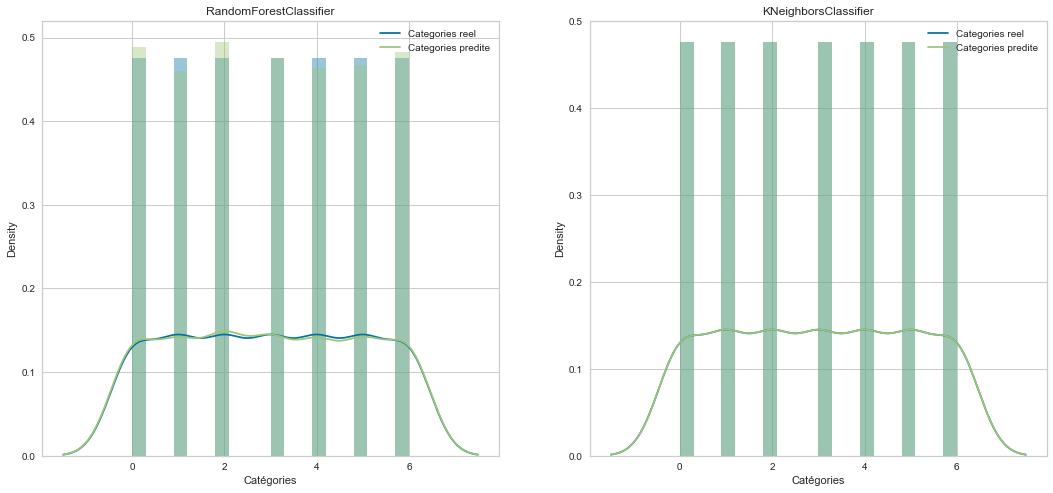

In [24]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,8))
axes=[ax1,ax2]
tnx=0
for knx in Classifiers:
    ax=axes[tnx]
    tnx=tnx+1
    x_cv_data=pred_train_improved[knx]
    sns.distplot(x_cv_data['lab_category'], bins=20, rug=False,ax=ax).set(title=knx)
    sns.distplot(x_cv_data['Cible predite'], bins=20, rug=False,ax=ax)
    ax.set_xlabel("Catégories")
    ax.legend(['Categories reel', 'Categories predite'])

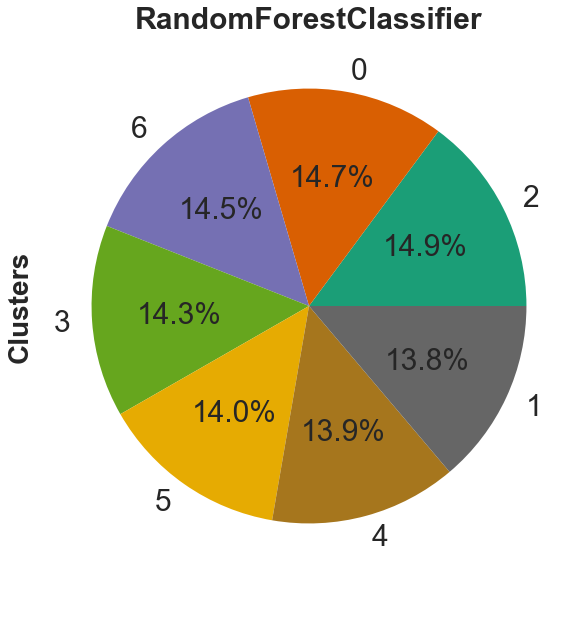

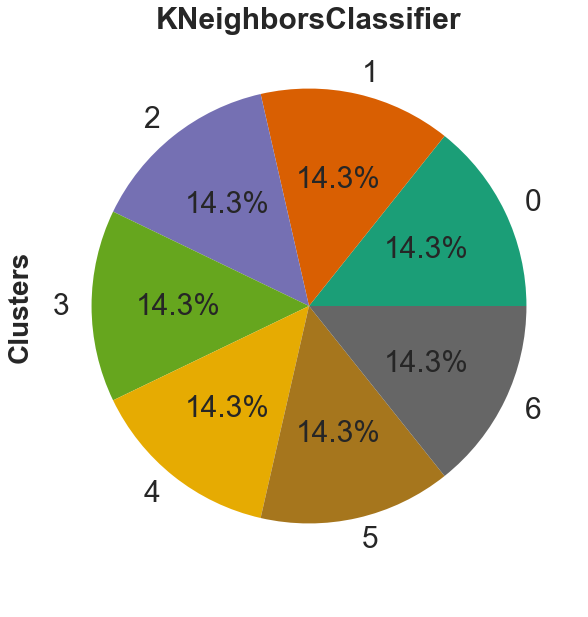

In [25]:
tnx=0
names=["RandomForestClassifier_pie_image.jpeg", "KNeighborsClassifier_pie_image.jpeg"]
dss=30
for knx in Classifiers:
        fig, ax2 = plt.subplots(figsize=(25,10))
        x_cv_data=pred_train_improved[knx]
        data_plot_0 = x_cv_data.groupby('Cible predite').agg(Categories =('class','count'))
        data_plot_0 =data_plot_0.sort_values(by='Categories', ascending=False)
        data_plot_0.plot(kind='pie', x='Cible predite', y='Categories', 
        cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(knx,fontsize=dss, weight='bold');
        
        ax2.set_ylabel('Clusters', weight='bold', size=dss-2)
        ax2.set_xlabel('   ', weight='bold', size=dss)
        plt.xticks(fontsize=dss)
        plt.grid(False)
        plt.xticks(fontsize=dss) 
        figure_name=names[tnx]
        
        plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
        tnx=tnx+1
        
!cp "RandomForestClassifier_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "RandomForestClassifier_pie_image.jpeg"  /home/yonss/Bureau/Data_scientist/FIGURE/P6
!cp "KNeighborsClassifier_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KNeighborsClassifier_pie_image.jpeg"  /home/yonss/Bureau/Data_scientist/FIGURE/P6


### Transfert learning VGG16 

In [26]:
imgs = []
labels = []
IMAGE_SIZE=(150, 150)
final_data=[]
categ=[]
for image in data_merged['image']:
    # Open and resize the img
    img = cv2.imread(str(img_path)+'/'+image)
    
    # Convering to Gray
    #img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # convert all picture to the same size
    img = cv2.resize(img, IMAGE_SIZE) 
 
    # Amélioration contraste
   # img = cv2.equalizeHist(img) 

    # Débruitage
    img = cv2.fastNlMeansDenoising(img)

    # filtre gausien
    img = cv2.GaussianBlur(img, (5, 5), 1)
    
    indx=data_merged[data_merged['image'] == image].index.values
    lab = data_merged['lab_category'][indx]
    Cat = data_merged['Category_0'][indx]
                
    # Append the image 
    imgs.append(img)
    labels.append(lab)
    categ.append(Cat)

imgs = np.array(imgs, dtype = 'float32') 
labels = np.array(labels, dtype = 'int32') 
categ  = np.array(categ, dtype = 'str')
final_data.append((imgs, labels))      

In [27]:
imgs=imgs/255.0   # scale image

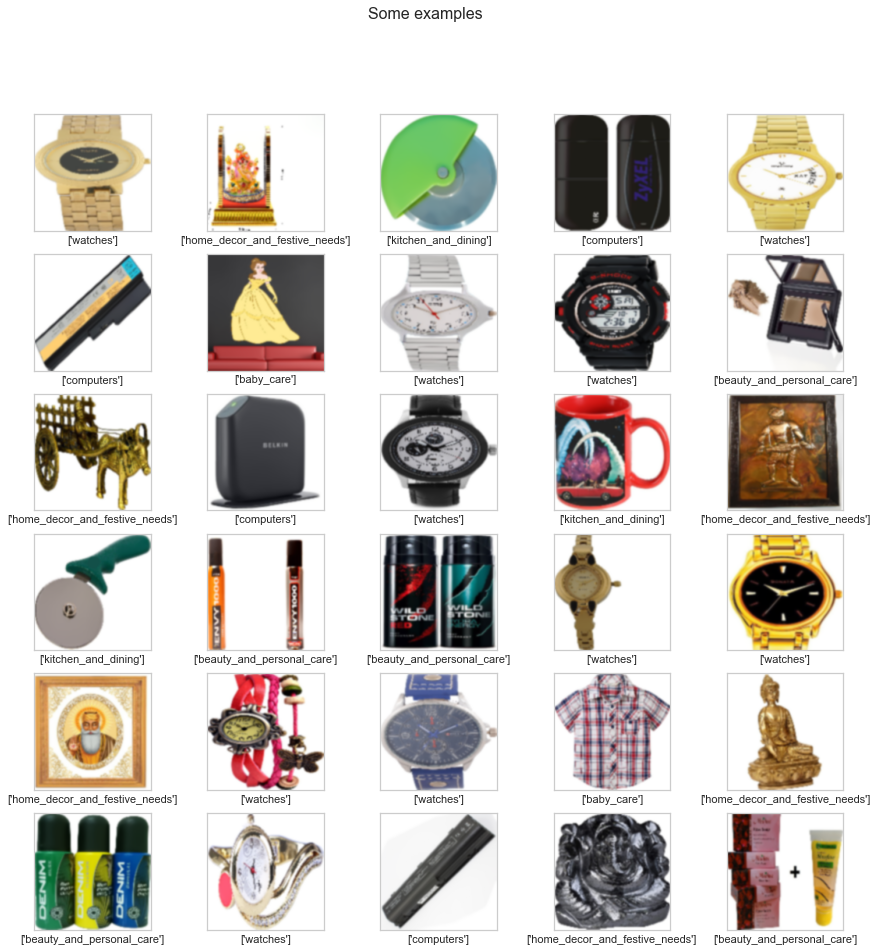

In [28]:
def display_examples(images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples", fontsize=16)
    for i in range(30):
        plt.subplot(6,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()


display_examples(imgs, categ)

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras import Input
from keras import Model

model = VGG16() # Création du modèle VGG-16 implementé par Keras


In [ ]:
my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 

# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(1000, activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(imgs, labels, batch_size=128, epochs=20, validation_split = 0.2)
